In [1]:
import networkx as nx

def twitter():
    G = nx.DiGraph()
    with open("twitter.txt", "r") as lines:
        for line in lines:
            a, b = line.split()
            G.add_edge(int(a), int(b))
    return G

In [3]:
from random import choice, random
from tabulate import tabulate

def cascade(G, retweet_prob = 0.07, candidates = [], table = True):
    start = choice(list(G.nodes()))

    S = list()
    S.append(start)
    visited = set()

    while S:
        curr = S.pop()

        if curr in visited or curr in candidates:
            continue

        visited.add(curr)
        neighbors = list(G.predecessors(curr))
        for neighbor in neighbors:
            if random() < retweet_prob:
                S.append(neighbor)

    N = G.number_of_nodes()
    V = len(visited)
    if table:
        print(
            tabulate(
                [
                    ["RETWEET PROBABILITY", retweet_prob],
                    ["N", N],
                    ["V", V],
                    ["CASCADE SIZE (V / N)", round(V / N, 2)],
                ],
                tablefmt="fancy_grid",
                numalign="left",
            )
        )
    else:
        return str(round(V / N, 2))

In [7]:
def joint_degree_distribution(G):
    outer_dict = dict()
    for edge in G.edges:
        out_deg = G.out_degree(edge[0])
        in_deg = G.in_degree(edge[1])
        if (out_deg in outer_dict):
            if (in_deg in outer_dict[out_deg]):
                outer_dict[out_deg][in_deg] += 1
            else:
                outer_dict[out_deg][in_deg] = 1
        else:
            outer_dict[out_deg] = dict()
            outer_dict[out_deg][in_deg] = 1
    return outer_dict
    
jdd = joint_degree_distribution(G)


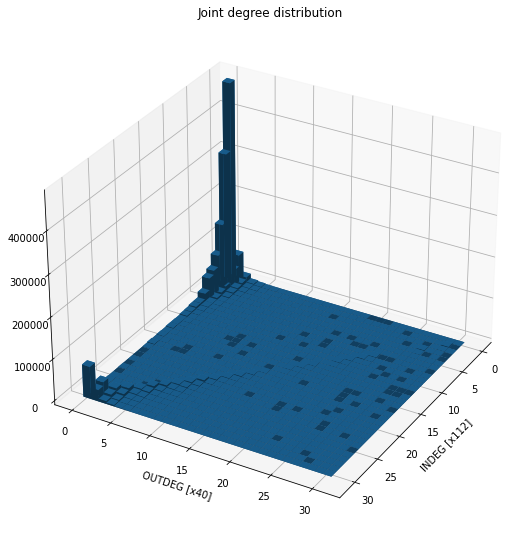

In [8]:
import numpy as np
import matplotlib.pyplot as plt

max_in = max(list(map(lambda x: x[1], G.in_degree(G.nodes))))
max_out = max(list(map(lambda x: x[1], G.out_degree(G.nodes))))
max_in, max_out

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection="3d")

size = 30
x_step = max_in // size
y_step = max_out // size
_x = np.arange(size + 1)
_y = np.arange(size + 1)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
ax.set_xlabel(f"INDEG [x{x_step}]")
ax.set_ylabel(f"OUTDEG [x{y_step}]")

z = np.zeros_like(x)
for i in jdd.keys():
    for key, val in jdd[i].items():
        a = i // y_step
        b = key // x_step
        z[a + b * size] += val

bottom = np.zeros_like(z)
width = depth = 1

ax.bar3d(x, y, bottom, width, depth, z, shade=True)
ax.set_title("Joint degree distribution")
ax.azim = 30

plt.show()

In [9]:
# DIAGONAL
diags = []
for node in list(G.nodes()):
    indeg = G.in_degree(node)
    outdeg = G.out_degree(node)
    
    _x = indeg // x_step
    _y = outdeg // y_step

    if abs(_x + _y - size) < 20:
        diags.append(node)

# LOW OUT, HIGH IN
lowout_highin = []
for node in list(G.nodes()):
    indeg = G.in_degree(node)
    outdeg = G.out_degree(node)
    
    _x = indeg // x_step
    _y = outdeg // y_step

    if _x > 5 and _y < 25:
        lowout_highin.append(node)

# LOW OUT, LOW IN
lowout_lowin = []
for node in list(G.nodes()):
    indeg = G.in_degree(node)
    outdeg = G.out_degree(node)
    
    _x = indeg // x_step
    _y = outdeg // y_step

    if _x < 5 and _y < 5:
        if random() <= 0.002:
            lowout_lowin.append(node)

In [4]:
from collections import defaultdict

def simulate(N, retweet_prob, candidates):
    hist_pre = defaultdict(int)
    hist_post = defaultdict(int)

    prev_prog = 0
    print("PROGRESS: [", end="")
    for i in range(N):
        hist_pre[cascade(G, retweet_prob, [], False)] += 1
        
        prog = int((i / N) * 100)
        if prog % 10 == 0 and prog > prev_prog:
            print("#", end="")
            prev_prog = prog
    print("]")

    prev_prog = 0
    print("PROGRESS: [", end="")
    for i in range(N):
        hist_post[cascade(G, retweet_prob, candidates, False)] += 1
        
        prog = int((i / N) * 100)
        if prog % 10 == 0 and prog > prev_prog:
            print("#", end="")
            prev_prog = prog
    print("]")

    pre_vals = []
    pre_keys = []
    for key in sorted(hist_pre):
        pre_vals.append(hist_pre[key])
        pre_keys.append(key)

    post_vals = []
    post_keys = []
    for key in sorted(hist_post):
        post_vals.append(hist_post[key])
        post_keys.append(key)
    
    plt.figure()
    plt.bar(range(len(pre_vals)), pre_vals, align="center", label="Pre")
    plt.xticks(range(len(pre_keys)), pre_keys)

    plt.bar(range(len(post_vals)), post_vals, align="center", alpha=0.5, label="Post")
    plt.xticks(range(len(post_keys)), post_keys)
    plt.legend()

PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]


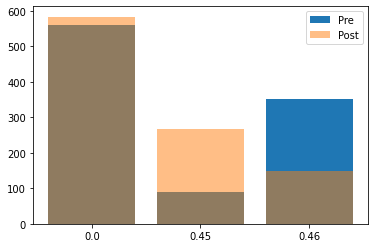

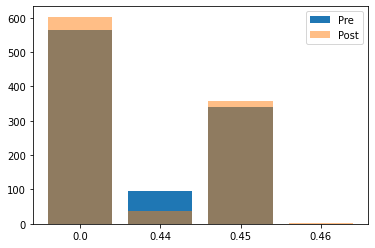

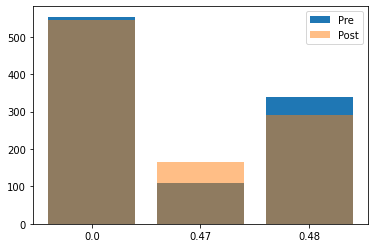

In [13]:
simulate(1000, 0.1, diags)
simulate(1000, 0.1, lowout_highin)
simulate(1000, 0.1, lowout_lowin)

PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]
PROGRESS: [#########]


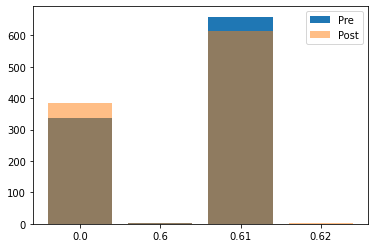

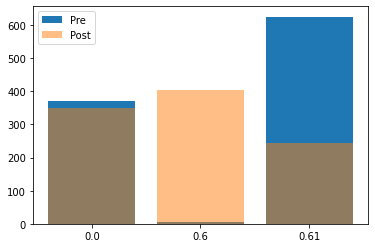

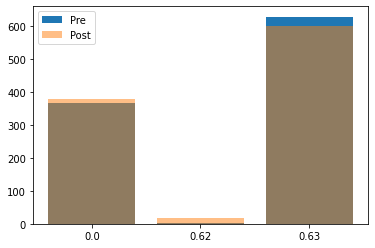

In [14]:
simulate(1000, 0.2, diags)
simulate(1000, 0.2, lowout_highin)
simulate(1000, 0.2, lowout_lowin)

# Identifying HWCC on Previous Cascades

In [28]:
import sys; sys.path.append(".")

%reload_ext autoreload
%autoreload 2

import networkx as nx
from project import twitter, cascade_att, simulate, simulate_agg
from operator import itemgetter

In [29]:
G = twitter()
num_of_candidates = 1000
retweet_prob = 0.026

for n in list(G.nodes):
    G.nodes[n]["cascaded"] = 0

print("GETTING CANDIATES PROGRESS: [", end="")
for i in range(100):
    if i % 10 == 0:
        print("#", end="")

    while not cascade_att(G, retweet_prob):
        continue
print("]")

trace = list(map(lambda x: (x, G.nodes[x]["cascaded"]), list(G.nodes)))
trace = sorted(trace, key=lambda x: x[1], reverse=True)
candidates = list(map(lambda x: x[0], trace))[:num_of_candidates]

GETTING CANDIATES PROGRESS: [##########]


In [30]:
# HIGHEST IN
highest_in = list(G.in_degree())
highest_in.sort(key=itemgetter(1), reverse=True)
in_candidates = list(map(lambda x: x[0], highest_in[:num_of_candidates]))

In [31]:
# HIGHEST OUT
highest_out = list(G.out_degree())
highest_out.sort(key=itemgetter(1), reverse=True)
out_candidates = list(map(lambda x: x[0], highest_out[:num_of_candidates]))

In [ ]:
# CLOSENESS (2 SLOW)
print("CALCULATING CLOSENESS")
cc = nx.closeness_centrality(G)
print("CLOSENESS CALCULATED")
nx.set_node_attributes(G, cc, "closeness")
print("CLOSENESS ADDED")

highest_bc = list(map(lambda x: (x, G.nodes[x]["closenss"]), list(G.nodes)))
highest_bc.sort(key=itemgetter(1), reverse=True)
bc_candidates = list(map(lambda x: x[0], highest_bc[:num_of_candidates]))

In [32]:
# CENTRALITY
print("CALCULATING EV CENTRALITY")
ec = nx.eigenvector_centrality(G, tol=1e-04)
print("EV CENTRALITY CALCULATED")
nx.set_node_attributes(G, ec, "ev")
print("EV CENTRALITY ADDED")

highest_ec = list(map(lambda x: (x, G.nodes[x]["ev"]), list(G.nodes)))
highest_ec.sort(key=itemgetter(1), reverse=True)
ec_candidates = list(map(lambda x: x[0], highest_ec[:num_of_candidates]))

CALCULATING EV CENTRALITY
EV CENTRALITY CALCULATED
EV CENTRALITY ADDED


In [33]:
# PageRank
print("CALCULATING PAGERANK")
pr = nx.pagerank(G)
print("PAGERANK CALCULATED")
nx.set_node_attributes(G, pr, "pr")
print("PAGERANK ADDED")

highest_pr = list(map(lambda x: (x, G.nodes[x]["pr"]), list(G.nodes)))
highest_pr.sort(key=itemgetter(1), reverse=True)
pr_candidates = list(map(lambda x: x[0], highest_pr[:num_of_candidates]))

CALCULATING PAGERANK
PAGERANK CALCULATED
PAGERANK ADDED


SELECTED PRE PROGRESS: [#########]
SELECTED POST PROGRESS: [#########]
HIGH IN PRE PROGRESS: [#########]
HIGH IN POST PROGRESS: [#########]
HIGH OUT PRE PROGRESS: [#########]
HIGH OUT POST PROGRESS: [#########]
EC CENTRALITY PRE PROGRESS: [#########]
EC CENTRALITY POST PROGRESS: [#########]
PR CENTRALITY PRE PROGRESS: [#########]
PR CENTRALITY POST PROGRESS: [#########]


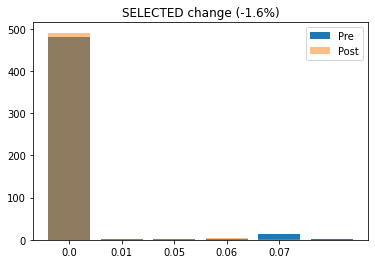

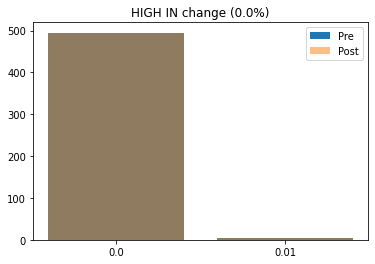

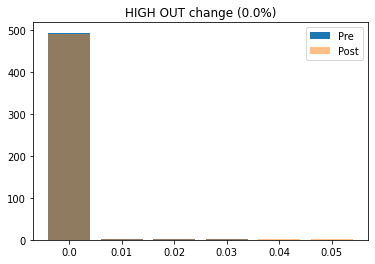

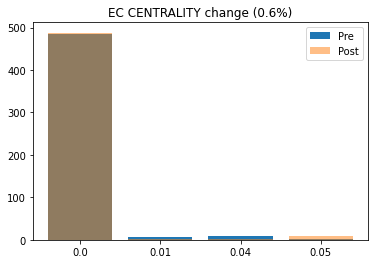

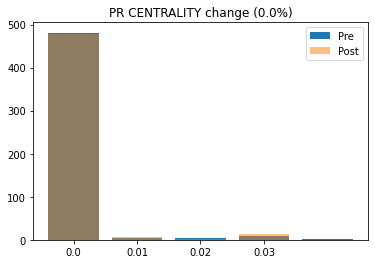

In [34]:
simulate(G, 500, retweet_prob, candidates, name="SELECTED")
simulate(G, 500, retweet_prob, in_candidates, name="HIGH IN")
simulate(G, 500, retweet_prob, out_candidates, name="HIGH OUT")
simulate(G, 500, retweet_prob, ec_candidates, name="EC CENTRALITY" )
simulate(G, 500, retweet_prob, pr_candidates, name="PR CENTRALITY" )

In [53]:
G = twitter()
num_of_candidates = 1500

# TRACE SELECTION
for n in list(G.nodes):
    G.nodes[n]["cascaded"] = 0

print("GETTING CANDIATES PROGRESS: [", end="")
for i in range(100):
    if i % 10 == 0:
        print("#", end="")

    while not cascade_att(G):
        continue
print("]")

trace = list(map(lambda x: (x, G.nodes[x]["cascaded"]), list(G.nodes)))
trace = sorted(trace, key=lambda x: x[1], reverse=True)
trace_candidates = list(map(lambda x: x[0], trace))[:num_of_candidates]

# HIGHEST IN
highest_in = list(G.in_degree())
highest_in.sort(key=itemgetter(1), reverse=True)
in_candidates = list(map(lambda x: x[0], highest_in[:num_of_candidates]))

# HIGHEST OUT
highest_out = list(G.out_degree())
highest_out.sort(key=itemgetter(1), reverse=True)
out_candidates = list(map(lambda x: x[0], highest_out[:num_of_candidates]))

# CENTRALITY
print("CALCULATING EV CENTRALITY")
ec = nx.eigenvector_centrality(G, tol=1e-04)
print("EV CENTRALITY CALCULATED")
nx.set_node_attributes(G, ec, "ev")
print("EV CENTRALITY ADDED")

highest_ec = list(map(lambda x: (x, G.nodes[x]["ev"]), list(G.nodes)))
highest_ec.sort(key=itemgetter(1), reverse=True)
ec_candidates = list(map(lambda x: x[0], highest_ec[:num_of_candidates]))

# PageRank
print("CALCULATING PAGERANK")
pr = nx.pagerank(G)
print("PAGERANK CALCULATED")
nx.set_node_attributes(G, pr, "pr")
print("PAGERANK ADDED")

highest_pr = list(map(lambda x: (x, G.nodes[x]["pr"]), list(G.nodes)))
highest_pr.sort(key=itemgetter(1), reverse=True)
pr_candidates = list(map(lambda x: x[0], highest_pr[:num_of_candidates]))

GETTING CANDIATES PROGRESS: [##########]
CALCULATING EV CENTRALITY
EV CENTRALITY CALCULATED
EV CENTRALITY ADDED
CALCULATING PAGERANK
PAGERANK CALCULATED
PAGERANK ADDED


In [54]:
retweet_prob = 0.026

sel = []
h_in = []
h_out = []
cen = []
pr = []

print("SIM PROGRESS: [", end="")
for i in range(15):
    N = i * 100
    sel.append(simulate_agg(G, 100, retweet_prob, trace_candidates[:N]))
    h_in.append(simulate_agg(G, 100, retweet_prob, in_candidates[:N]))
    h_out.append(simulate_agg(G, 100, retweet_prob, out_candidates[:N]))
    cen.append(simulate_agg(G, 100, retweet_prob, ec_candidates[:N]))
    pr.append(simulate_agg(G, 100, retweet_prob, pr_candidates[:N]))
    if i % 10 == 0:
        print("#", end="")
print("]")

SIM PROGRESS: [##

100 100


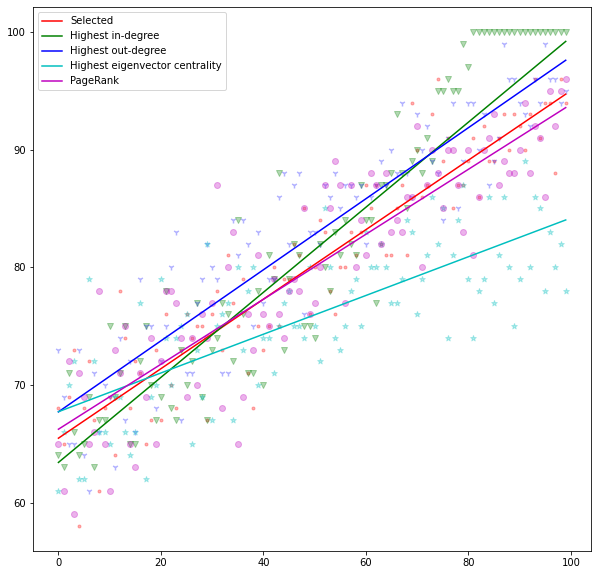

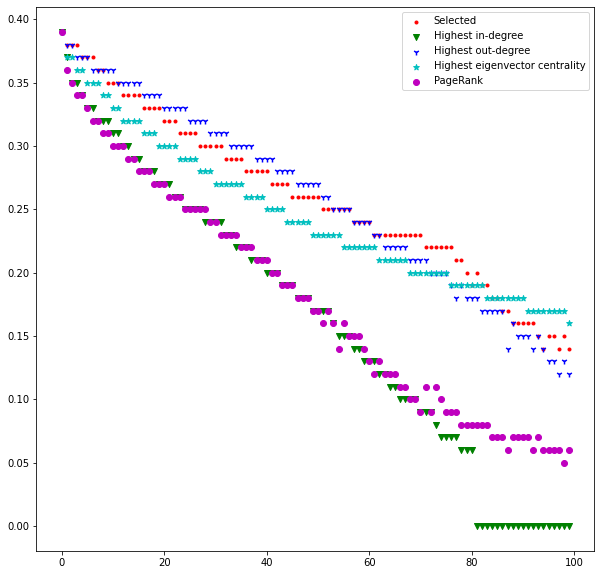

In [52]:
import numpy as np
from matplotlib import pyplot as plt

x = list(range(100))
print(len(sel), len(x))

plt.figure(figsize=(10, 10))
plt.scatter(x, list(map(lambda x: x[0], sel)), c="r", marker=".", alpha=0.3)
plt.scatter(x, list(map(lambda x: x[0], h_in)), c="g", marker="v", alpha=0.3)
plt.scatter(x, list(map(lambda x: x[0], h_out)), c="b", marker="1", alpha=0.3)
plt.scatter(x, list(map(lambda x: x[0], cen)), c="c", marker="*", alpha=0.3)
plt.scatter(x, list(map(lambda x: x[0], pr)), c="m", marker="o", alpha=0.3)
s_m, s_b = np.polyfit(x, list(map(lambda x: x[0], sel)), 1)
i_m, i_b = np.polyfit(x[:80], list(map(lambda x: x[0], h_in[:80])), 1)
o_m, o_b = np.polyfit(x, list(map(lambda x: x[0], h_out)), 1)
c_m, c_b = np.polyfit(x, list(map(lambda x: x[0], cen)), 1)
p_m, p_b = np.polyfit(x, list(map(lambda x: x[0], pr)), 1)
plt.plot(x, s_m * np.array(x) + s_b, c="r", label="Selected")
plt.plot(x, i_m * np.array(x) + i_b, c="g", label="Highest in-degree")
plt.plot(x, o_m * np.array(x) + o_b, c="b", label="Highest out-degree")
plt.plot(x, c_m * np.array(x) + c_b, c="c", label="Highest eigenvector centrality")
plt.plot(x, p_m * np.array(x) + p_b, c="m", label="PageRank")
plt.legend()

plt.figure(figsize=(10, 10))
plt.scatter(x, list(map(lambda x: x[1], sel)), c="r", marker=".", label="Selected")
plt.scatter(x, list(map(lambda x: x[1], h_in)), c="g", marker="v", label="Highest in-degree")
plt.scatter(x, list(map(lambda x: x[1], h_out)), c="b", marker="1", label="Highest out-degree")
plt.scatter(x, list(map(lambda x: x[1], cen)), c="c", marker="*", label="Highest eigenvector centrality")
plt.scatter(x, list(map(lambda x: x[1], pr)), c="m", marker="o", label="PageRank")
plt.legend()